In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np

import datetime
from dateutil.relativedelta import relativedelta 

import random

from catboost import CatBoostClassifier

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from utils import add_time_series_features, add_master_data_mappings, evaluate

tqdm.pandas()

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

In [2]:
data_path = "./data/fact_train_test.csv"
data = pd.read_csv(data_path, sep=";", decimal=",", encoding="windows-1251")
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3


### Preprocessing

In [3]:
data["period"] = pd.to_datetime(data["period"], format="%Y-%m-%d", errors='coerce')

In [4]:
date_min = data["period"].min()
date_max = data["period"].max()
data["months_from_start"] = (data["period"].dt.year - date_min.year) * 12 + (data["period"].dt.month - date_min.month)
data

data = data.drop(columns=["period"])

In [5]:
accuracy_granularity = [
    # "period",
    "rps",
    # "holding_name",
    # "sender_department_name",
    # "recipient_department_name",
    
    "client_sap_id",
    "freight_id",
    "sender_station_id",
    "recipient_station_id",
    "sender_organisation_id",
    "podrod",
    "filial",
]

In [6]:
data_grouped = data.groupby(accuracy_granularity).agg(list)
data_grouped

real_weight  \
rps client_sap_id freight_id sender_station_id recipient_station_id sender_organisation_id podrod filial                   
0   -1            0          2977              38567                7152                   0      2               [31.0]   
                             3801              26930                7152                   1      2               [90.0]   
                             3845              28207                8535                   1      2                [4.0]   
                             4602              31057                0                      0      2               [40.0]   
                             4871              25250                0                      1      2         [68.0, 68.0]   
...                                                                                                                  ...   
1    2415         2997       13005             33625                10441                  5      2       [136.0, 138.0]   
                                               37870                10441                  5      2        [70.0, 137.0]   
                  3471       32800             12142                7178                   5      2               [67.0]   
                                               12840                7178                   5      2               [67.0]   
     2416         1691       27096             27484                10579                  5      2       [130.0, 130.0]   

                                                                                                         real_wagon_count  \
rps client_sap_id freight_id sender_station_id recipient_station_id sender_organisation_id podrod filial                    
0   -1            0          2977              38567                7152                   0      2                   [1]   
                             3801              26930                7152                   1      2                   [4]   
                             3845              28207                8535                   1      2                   [1]   
                             4602              31057                0                      0      2                   [2]   
                             4871              25250                0                      1      2                [1, 1]   
...                                                                                                                   ...   
1    2415         2997       13005             33625                10441                  5      2                [2, 2]   
                                               37870                10441                  5      2                [1, 2]   
                  3471       32800             12142                7178                   5      2                   [1]   
                                               12840                7178                   5      2                   [1]   
     2416         1691       27096             27484                10579                  5      2                [2, 2]   

                                                                                                         months_from_start  
rps client_sap_id freight_id sender_station_id recipient_station_id sender_organisation_id podrod filial                    
0   -1            0          2977              38567                7152                   0      2                   [83]  
                             3801              26930                7152                   1      2                   [76]  
                             3845              28207                8535                   1      2                   [74]  
                             4602              31057                0                      0      2                   [55]  
                             4871              25250                0                      1      2               [62, 6

In [7]:
not_grouped_indexes = list(data_grouped.columns)
not_grouped_indexes

['real_weight', 'real_wagon_count', 'months_from_start']

In [8]:
for months in data_grouped["months_from_start"].tolist():
    if len(set(months)) != len(months):
        raise

In [9]:
# data_grouped = data_grouped.reset_index()
# data_grouped

In [10]:
k_ns = 0

def negative_sampling(column):
    if column.name == "real_weight":
        column = [line + [0] * k_ns for line in column]
    elif column.name == "real_wagon_count":
        column = [line + [0] * k_ns for line in column]
    elif column.name == "months_from_start":
        column = [line + random.sample(list(set(range(54, 128 + 1)) - set(line)), k_ns) for line in column]
    return column

In [11]:
data_with_ns = data_grouped.copy()
data_with_ns[not_grouped_indexes] = data_grouped[not_grouped_indexes].progress_apply(negative_sampling)

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
data_with_ns = data_with_ns.explode(not_grouped_indexes).reset_index()

In [13]:
data_with_ns["is_history"] = ((data_with_ns["real_weight"] != 0) | (data_with_ns["real_wagon_count"] != 0)).astype(int)

In [14]:
data_with_ns = add_master_data_mappings(data_with_ns)

In [15]:
data_with_ns

,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,real_weight,real_wagon_count,months_from_start,is_history,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,0,-1,0,2977,38567,7152,0,2,31.0,1,83,1,NaN,0,27,25,76,6
1,0,-1,0,3801,26930,7152,1,2,90.0,4,76,1,NaN,0,130,25,123,31
2,0,-1,0,3845,28207,8535,1,2,4.0,1,74,1,NaN,0,130,25,11,27
3,0,-1,0,4602,31057,0,0,2,40.0,2,55,1,NaN,0,81,17,4,12
4,0,-1,0,4871,25250,0,1,2,68.0,1,62,1,NaN,0,58,13,127,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,1,2415,2997,13005,37870,10441,5,2,137.0,2,71,1,2046.0,34,75,4,154,3
3559228,1,2415,3471,32800,12142,7178,5,2,67.0,1,80,1,2046.0,30,119,29,54,4
3559229,1,2415,3471,32800,12840,7178,5,2,67.0,1,76,1,2046.0,30,119,29,36,4
3559230,1,2416,1691,27096,27484,10579,5,2,130.0,2,105,1,1935.0,39,86,39,94,39


In [16]:
data_with_ns["period"] = (date_min + data_with_ns["months_from_start"].progress_apply(lambda x: relativedelta(months=x)))
data_with_ns

  0%|          | 0/3559232 [00:00<?, ?it/s]

,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,real_weight,real_wagon_count,months_from_start,is_history,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,period
0,0,-1,0,2977,38567,7152,0,2,31.0,1,83,1,NaN,0,27,25,76,6,2019-06-01 00:00:00
1,0,-1,0,3801,26930,7152,1,2,90.0,4,76,1,NaN,0,130,25,123,31,2018-11-01 00:00:00
2,0,-1,0,3845,28207,8535,1,2,4.0,1,74,1,NaN,0,130,25,11,27,2018-09-01 00:00:00
3,0,-1,0,4602,31057,0,0,2,40.0,2,55,1,NaN,0,81,17,4,12,2017-02-01 00:00:00
4,0,-1,0,4871,25250,0,1,2,68.0,1,62,1,NaN,0,58,13,127,1,2017-09-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,1,2415,2997,13005,37870,10441,5,2,137.0,2,71,1,2046.0,34,75,4,154,3,2018-06-01 00:00:00
3559228,1,2415,3471,32800,12142,7178,5,2,67.0,1,80,1,2046.0,30,119,29,54,4,2019-03-01 00:00:00
3559229,1,2415,3471,32800,12840,7178,5,2,67.0,1,76,1,2046.0,30,119,29,36,4,2018-11-01 00:00:00
3559230,1,2416,1691,27096,27484,10579,5,2,130.0,2,105,1,1935.0,39,86,39,94,39,2021-04-01 00:00:00


In [17]:
data_with_ns, date_features = add_time_series_features(data_with_ns)
data_with_ns = data_with_ns.drop(columns=["period_day", "period_seconds", "period_weekday"])

In [18]:
data_with_ns = data_with_ns.fillna(-1)

In [19]:
data_with_ns["is_test"] = (data_with_ns["months_from_start"] >= 124).astype(int)
data_with_ns = data_with_ns[data_with_ns["months_from_start"] >= 54]
data_with_ns

,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,real_weight,real_wagon_count,...,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,period,period_year,period_month,is_test
0,0,-1,0,2977,38567,7152,0,2,31.0,1,...,-1.0,0,27,25,76,6,2019-06-01,2019,6,0
1,0,-1,0,3801,26930,7152,1,2,90.0,4,...,-1.0,0,130,25,123,31,2018-11-01,2018,11,0
2,0,-1,0,3845,28207,8535,1,2,4.0,1,...,-1.0,0,130,25,11,27,2018-09-01,2018,9,0
3,0,-1,0,4602,31057,0,0,2,40.0,2,...,-1.0,0,81,17,4,12,2017-02-01,2017,2,0
4,0,-1,0,4871,25250,0,1,2,68.0,1,...,-1.0,0,58,13,127,1,2017-09-01,2017,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,1,2415,2997,13005,37870,10441,5,2,137.0,2,...,2046.0,34,75,4,154,3,2018-06-01,2018,6,0
3559228,1,2415,3471,32800,12142,7178,5,2,67.0,1,...,2046.0,30,119,29,54,4,2019-03-01,2019,3,0
3559229,1,2415,3471,32800,12840,7178,5,2,67.0,1,...,2046.0,30,119,29,36,4,2018-11-01,2018,11,0
3559230,1,2416,1691,27096,27484,10579,5,2,130.0,2,...,1935.0,39,86,39,94,39,2021-04-01,2021,4,0


In [20]:
data_with_ns = data_with_ns.sort_values(["months_from_start"])

### CatBoost

In [54]:
train = data_with_ns[data_with_ns["is_test"] == 0]
test = data_with_ns[data_with_ns["is_test"] == 1]

# train = train[(train["real_weight"] != 0) | (train["real_wagon_count"] != 0)]

X_train = train.drop(columns=["real_weight", "real_wagon_count", "is_history", "is_test"])
y_train = train["is_history"].tolist()
X_test = test.drop(columns=["real_weight", "real_wagon_count", "is_history", "is_test"])
y_test = test["is_history"].tolist()

In [95]:
# cat_features = ["rps", "podrod", "filial", "recipient_department_name", "recipient_railway_name"]
cat_features = ["recipient_department_name", "recipient_railway_name"]
model = CatBoostClassifier(iterations=20,
                           eval_metric="Accuracy",
                           use_best_model=True,
                           random_seed=42,
                           max_depth=16,
                           loss_function="CrossEntropy",
                           # cat_features=cat_features,
                           learning_rate=0.5,
)

model.fit(X_train,
          y_train,
          eval_set=(X_test, y_test),
          verbose=10)

0:	learn: 0.9917320	test: 0.9904674	best: 0.9904674 (0)	total: 453ms	remaining: 8.61s
10:	learn: 0.9932072	test: 0.9940501	best: 0.9940501 (10)	total: 5.03s	remaining: 4.12s
19:	learn: 0.9938381	test: 0.9942878	best: 0.9943289 (17)	total: 9.13s	remaining: 0us

bestTest = 0.9943288793
bestIteration = 17

Shrink model to first 18 iterations.


150, 3, 0.1: 0.9362684

150, 4, 0.1: 0.9379314

150, 7, 0.1: 0.9387160

100, 16, 0.2: 0.9397679

ns_k = 0, 70, 13, 0.5: 0.9945848

In [96]:
probs_test = model.predict_proba(X_test)[:, 1]

In [97]:
from sklearn.metrics import accuracy_score

accuracies = []

thresholds = np.arange(0, 1, 0.01)

for thresh in thresholds:
    probs_test_i = probs_test.copy()
    probs_test_i[probs_test_i > thresh] = 1
    probs_test_i[probs_test_i < thresh] = 0

    accuracies.append(accuracy_score(y_test, probs_test_i))

In [98]:
accuracies[70]

0.9939450161770889

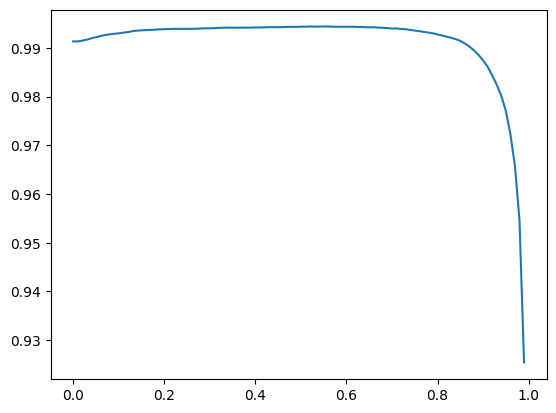

In [99]:
plt.plot(thresholds, accuracies)

In [100]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()

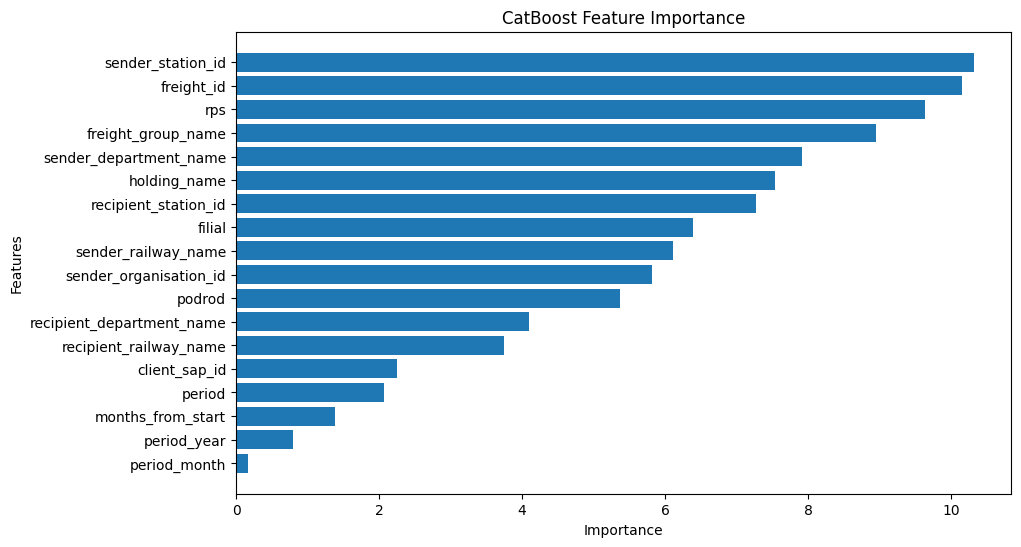

In [101]:
plt.figure(figsize=(10, 6))

plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

In [130]:
data_grouped_local = data[data["months_from_start"] <= 123].groupby(accuracy_granularity).agg(list)

In [135]:
wagon_predict = X_train[X_train["months_from_start"] >= 123]

# wagon_predict["predict"] = model.predict(wagon_predict)
# wagon_predict = wagon_predict[wagon_predict["predict"] == 1].drop(columns=["predict"])

wagon_predict["forecast_wagon_count"] = train["real_wagon_count"]
wagon_predict["forecast_weight"] = train["real_weight"]
wagon_predict = wagon_predict.groupby(accuracy_granularity).agg(list)
wagon_predict["forecast_wagon_count"] = wagon_predict["forecast_wagon_count"].apply(lambda x: x[-1])
wagon_predict["forecast_weight"] = wagon_predict["forecast_weight"].apply(lambda x: x[-1])
wagon_predict = wagon_predict.explode(list(set(wagon_predict.columns) - {"forecast_weight", "forecast_wagon_count"})).reset_index()

wagon_predict["full_history_wagon_count"] = data_grouped.loc[list(wagon_predict[data_grouped.index.names].itertuples(index=False))].reset_index()["real_wagon_count"]
wagon_predict["history_wagon_count"] = data_grouped_local.loc[list(wagon_predict[data_grouped_local.index.names].itertuples(index=False))].reset_index()["real_wagon_count"]


dates = [datetime.datetime.strptime("2022-11-01", "%Y-%m-%d"),
         datetime.datetime.strptime("2022-12-01", "%Y-%m-%d"),
         datetime.datetime.strptime("2023-01-01", "%Y-%m-%d"),
         datetime.datetime.strptime("2023-02-01", "%Y-%m-%d"),
         datetime.datetime.strptime("2023-03-01", "%Y-%m-%d")
]
wagon_predict["period"] = [dates.copy() for _ in range(wagon_predict.shape[0])]
wagon_predict["period_year"] = [[2022, 2022, 2023, 2023, 2023] for _ in range(wagon_predict.shape[0])]
wagon_predict["period_month"] = [[11, 12, 1, 2, 3] for _ in range(wagon_predict.shape[0])]
wagon_predict["months_from_start"] = [[124, 125, 126, 127, 128] for _ in range(wagon_predict.shape[0])]

wagon_predict = wagon_predict.explode(["months_from_start", "period_month", "period_year", "period"])

wagon_predict["forecast_wagon_count"] = (wagon_predict["history_wagon_count"].apply(lambda x: sum(x) / len(x)) + wagon_predict["forecast_wagon_count"]) / 2
wagon_predict = wagon_predict.drop(columns=["history_wagon_count", "full_history_wagon_count"])


# wagon_predict = wagon_predict.drop_duplicates()

wagon_predict

/var/folders/ww/n61vmv4529s__kvnf2d_7x_jlkmr7f/T/ipykernel_16290/2693074929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wagon_predict["forecast_wagon_count"] = train["real_wagon_count"]
/var/folders/ww/n61vmv4529s__kvnf2d_7x_jlkmr7f/T/ipykernel_16290/2693074929.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wagon_predict["forecast_weight"] = train["real_weight"]


,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,months_from_start,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,period,period_year,period_month,forecast_wagon_count,forecast_weight
0,0,-1,3,10165,35434,26119,0,1,124,-1.0,5,111,23,104,10,2022-11-01,2022,11,1.833333,60.0
0,0,-1,3,10165,35434,26119,0,1,125,-1.0,5,111,23,104,10,2022-12-01,2022,12,1.833333,60.0
0,0,-1,3,10165,35434,26119,0,1,126,-1.0,5,111,23,104,10,2023-01-01,2023,1,1.833333,60.0
0,0,-1,3,10165,35434,26119,0,1,127,-1.0,5,111,23,104,10,2023-02-01,2023,2,1.833333,60.0
0,0,-1,3,10165,35434,26119,0,1,128,-1.0,5,111,23,104,10,2023-03-01,2023,3,1.833333,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45909,1,2411,1691,37614,33108,27749,5,2,124,112.0,39,55,3,43,29,2022-11-01,2022,11,1.000000,48.0
45909,1,2411,1691,37614,33108,27749,5,2,125,112.0,39,55,3,43,29,2022-12-01,2022,12,1.000000,48.0
45909,1,2411,1691,37614,33108,27749,5,2,126,112.0,39,55,3,43,29,2023-01-01,2023,1,1.000000,48.0
45909,1,2411,1691,37614,33108,27749,5,2,127,112.0,39,55,3,43,29,2023-02-01,2023,2,1.000000,48.0


In [136]:
forecast = wagon_predict.copy()

fact = X_test.copy()
fact["real_wagon_count"] = test["real_wagon_count"]
fact["real_weight"] = test["real_weight"]

In [137]:
evaluate(fact, forecast, public=True), evaluate(fact, forecast, public=False)

(0.6279056525761059, 0.6237398240996451)

base: (0.6256036771899312, 0.6209392649112275)

base 122-123: (0.606534460674542, 0.60113762769287)

base + clf: (0.6257838025721237, 0.6206771161246444)

In [31]:
model = CatBoostClassifier(iterations=134,
                           eval_metric="AUC",
                           # use_best_model=True,
                           random_seed=42,
                           max_depth=3,
                           # cat_features=cat_features,
                           learning_rate=0.1
)

full_X = data_with_ns.drop(columns=["real_weight", "real_wagon_count", "is_history", "is_test"])
full_y = data_with_ns["is_history"].tolist()

model.fit(full_X,
          full_y,
          verbose=50
)

0:	total: 116ms	remaining: 15.4s
50:	total: 4.01s	remaining: 6.52s
100:	total: 7.81s	remaining: 2.55s
133:	total: 10.3s	remaining: 0us


### Predict

In [48]:
data_grouped_predict = data_grouped[data_grouped["months_from_start"].apply(max) >= 127]
# TODO: Change 54 to 2020-01-01

In [49]:
date = datetime.datetime.strptime("2023-03-01", "%Y-%m-%d")
(date.year - date_min.year) * 12 + (date.month - date_min.month)

128

In [50]:
data_grouped_predict = data_grouped_predict.drop(columns=["real_weight", "real_wagon_count"])
data_grouped_predict["months_from_start"] = [[129, 130, 131, 132, 133] for _ in range(data_grouped_predict.shape[0])]
data_grouped_predict

months_from_start
rps client_sap_id freight_id sender_station_id recipient_station_id sender_organisation_id podrod filial                           
0   -1            3          10165             30710                26119                  0      1       [129, 130, 131, 132, 133]
                                               30729                26119                  0      1       [129, 130, 131, 132, 133]
                                               30807                26119                  0      1       [129, 130, 131, 132, 133]
                                               30892                26119                  0      1       [129, 130, 131, 132, 133]
                                               31371                26119                  0      1       [129, 130, 131, 132, 133]
...                                                                                                                             ...
1    2410         1682       32810             38316                28657                  5      1       [129, 130, 131, 132, 133]
                  1691       32810             11445                25813                  4      2       [129, 130, 131, 132, 133]
                                                                                           5      2       [129, 130, 131, 132, 133]
                                               27374                25813                  4      2       [129, 130, 131, 132, 133]
                  1705       32810             37493                28657                  5      1       [129, 130, 131, 132, 133]

[69629 rows x 1 columns]

In [51]:
data_future_months = data_grouped_predict.explode(["months_from_start"]).reset_index()

In [52]:
data_future_months = add_master_data_mappings(data_future_months)

In [53]:
data_future_months["period"] = (date_min + data_future_months["months_from_start"].progress_apply(lambda x: relativedelta(months=x)))
data_future_months

  0%|          | 0/348145 [00:00<?, ?it/s]

,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,months_from_start,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,period
0,0,-1,3,10165,30710,26119,0,1,129,NaN,5,111,23,2,12,2023-04-01 00:00:00
1,0,-1,3,10165,30710,26119,0,1,130,NaN,5,111,23,2,12,2023-05-01 00:00:00
2,0,-1,3,10165,30710,26119,0,1,131,NaN,5,111,23,2,12,2023-06-01 00:00:00
3,0,-1,3,10165,30710,26119,0,1,132,NaN,5,111,23,2,12,2023-07-01 00:00:00
4,0,-1,3,10165,30710,26119,0,1,133,NaN,5,111,23,2,12,2023-08-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348140,1,2410,1705,32810,37493,28657,5,1,129,112.0,39,103,29,137,3,2023-04-01 00:00:00
348141,1,2410,1705,32810,37493,28657,5,1,130,112.0,39,103,29,137,3,2023-05-01 00:00:00
348142,1,2410,1705,32810,37493,28657,5,1,131,112.0,39,103,29,137,3,2023-06-01 00:00:00
348143,1,2410,1705,32810,37493,28657,5,1,132,112.0,39,103,29,137,3,2023-07-01 00:00:00


In [54]:
data_future_months, date_features = add_time_series_features(data_future_months)
data_future_months = data_future_months.drop(columns=["period_day", "period_seconds", "period_weekday"])

In [55]:
data_future_months = data_future_months.fillna(-1)

In [56]:
data_future_months["predicts"] = (model.predict_proba(data_future_months)[:, 1] >= 0.7).astype(int)

In [57]:
data_future_months.shape

(348145, 19)

In [58]:
data_future_months = data_future_months[data_future_months["predicts"] == 1].reset_index()

In [59]:
# list(data_future_months[data_grouped.index.names].itertuples(index=False))

In [60]:
data_future_months["forecast_wagon_count"] = data_grouped.loc[list(data_future_months[data_grouped.index.names].itertuples(index=False))].reset_index()["real_wagon_count"].apply(lambda x: x[-1])
data_future_months["forecast_weight"] = data_grouped.loc[list(data_future_months[data_grouped.index.names].itertuples(index=False))].reset_index()["real_weight"].apply(lambda x: x[-1])
data_future_months

,index,rps,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,podrod,filial,months_from_start,...,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,period,period_year,period_month,predicts,forecast_wagon_count,forecast_weight
0,0,0,-1,3,10165,30710,26119,0,1,129,...,111,23,2,12,2023-04-01,2023,4,1,1,60.0
1,1,0,-1,3,10165,30710,26119,0,1,130,...,111,23,2,12,2023-05-01,2023,5,1,1,60.0
2,2,0,-1,3,10165,30710,26119,0,1,131,...,111,23,2,12,2023-06-01,2023,6,1,1,60.0
3,3,0,-1,3,10165,30710,26119,0,1,132,...,111,23,2,12,2023-07-01,2023,7,1,1,60.0
4,4,0,-1,3,10165,30710,26119,0,1,133,...,111,23,2,12,2023-08-01,2023,8,1,1,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339180,348140,1,2410,1705,32810,37493,28657,5,1,129,...,103,29,137,3,2023-04-01,2023,4,1,1,55.0
339181,348141,1,2410,1705,32810,37493,28657,5,1,130,...,103,29,137,3,2023-05-01,2023,5,1,1,55.0
339182,348142,1,2410,1705,32810,37493,28657,5,1,131,...,103,29,137,3,2023-06-01,2023,6,1,1,55.0
339183,348143,1,2410,1705,32810,37493,28657,5,1,132,...,103,29,137,3,2023-07-01,2023,7,1,1,55.0


In [61]:
example = pd.read_csv("./data/forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")

In [45]:
submission = data_future_months[example.columns]

In [46]:
submission.to_csv("./submission/classifier_5.csv", sep=";", decimal=",", encoding="windows-1251", index=False)

In [47]:
submission.shape

(339185, 11)